In [239]:
import pandas as pd
import numpy as np

pd_DataSet = pd.read_excel("C:\\Users\\KOPO\\Desktop\\SALES_DATA.xlsx", sheet_name="DIV별판매량")
print(pd_DataSet.columns)

Index(['DIV', '1M', '2M', '3M', '1,2월변화', '2,3월변화', '1_2', '2_3', '변화율'], dtype='object')


In [240]:
New_DF = pd_DataSet[['DIV','1_2', '2_3', '변화율']].dropna()
New_DF['1_2'] = pd.to_numeric(New_DF['1_2'], errors='coerce')
New_DF['2_3'] = pd.to_numeric(New_DF['2_3'], errors='coerce')
New_DF['변화율'] = pd.to_numeric(New_DF['변화율'], errors='coerce')
print(New_DF.head())

                 DIV        1_2        2_3        변화율
0  Baby & Child Care  -6.719319  14.693040   3.986860
1        Family Care  -6.368800   1.476738  -2.446031
2        Youth Pants  22.399803 -20.431457   0.984173
3        Health Care -26.675148   6.468941 -10.103104
4         Wet Tissue  10.474232 -23.973586  -6.749677


In [ ]:
# IQR 기반 이상치 탐지 및 제거 함수
def filter_outliers(df, columns):
    no_outliers_df = df
    outliers_df = pd.DataFrame()

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 이상치와 이상치가 아닌 데이터를 구분하여 각각 저장
        outliers_df = pd.concat([outliers_df, no_outliers_df[(no_outliers_df[column] < lower_bound) | (no_outliers_df[column] > upper_bound)]])  # 제거된 이상치
        no_outliers_df = no_outliers_df[(no_outliers_df[column] >= lower_bound) & (no_outliers_df[column] <= upper_bound)]  # 이상치가 아님

    return no_outliers_df, outliers_df.drop_duplicates().reset_index(drop=True)

# '1_2'와 '2_3' 열에 대해 이상치 제거
New_DF_no_outliers, removed_outliers = filter_outliers(New_DF, ['1_2', '2_3'])

# 결과 확인
print(f"이상치 제거 전 데이터 개수: {len(New_DF)}")
print(f"이상치 제거 후 데이터 개수: {len(New_DF_no_outliers)}")
print(removed_outliers)


이상치 제거 전 데이터 개수: 8
이상치 제거 후 데이터 개수: 7
          DIV         1_2       2_3        변화율
0  Adult Care -193.734636  9.077132 -92.328752


In [ ]:
from sklearn.preprocessing import StandardScaler
# 1_2, 2_3 표준화
scaler = StandardScaler()
growth_rate_scaled = scaler.fit_transform(New_DF_no_outliers[['1_2', '2_3']])

# 표준화 확인
print("Mean of each feature after standardization:", np.mean(growth_rate_scaled, axis=0))
print("Standard deviation of each feature after standardization:", np.std(growth_rate_scaled, axis=0))


Mean of each feature after standardization: [5.94762335e-17 3.96508223e-17]
Standard deviation of each feature after standardization: [1. 1.]


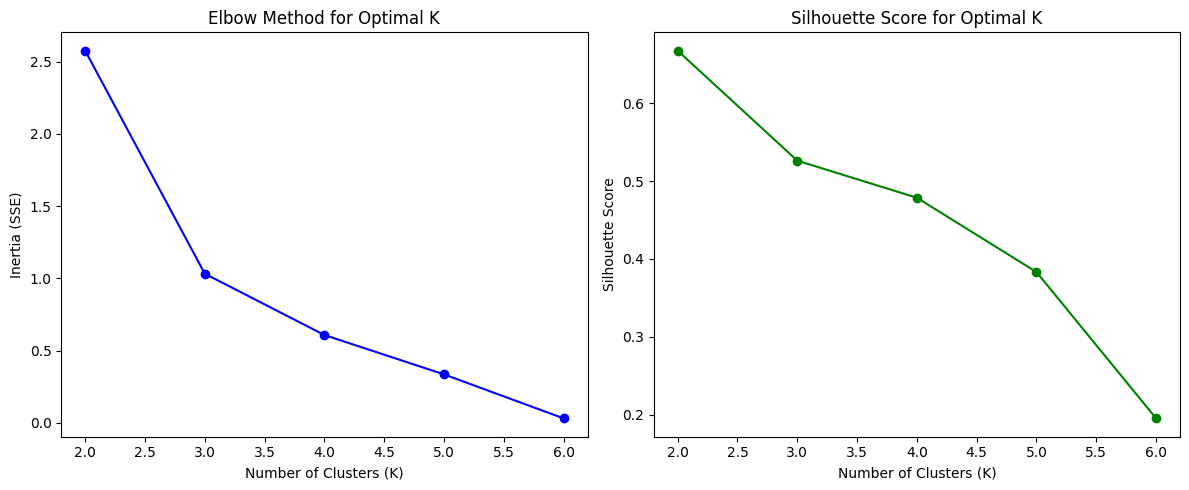

In [243]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 최적의 K 값 찾기 (엘보우와 실루엣 점수)
inertia = []  # 엘보우 방법을 위한 리스트
silhouette_scores = []  # 실루엣 점수를 위한 리스트
k_values = range(2, min(10, len(growth_rate_scaled)))  # K 값 범위 설정

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(growth_rate_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(growth_rate_scaled, kmeans.labels_))

# 엘보우 방법과 실루엣 점수 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method for Optimal K')

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')

plt.tight_layout()
plt.show()


In [244]:
# KMeans 클러스터링
kmeans_final = KMeans(n_clusters=3, random_state=42)
final_clusters = kmeans_final.fit_predict(growth_rate_scaled)

# 군집 결과를 원본 데이터에 추가
New_DF_no_outliers['Cluster'] = final_clusters  # 클러스터 결과를 바로 추가

# 결과 출력
print(New_DF_no_outliers)


                 DIV        1_2        2_3        변화율  Cluster
0  Baby & Child Care  -6.719319  14.693040   3.986860        1
1        Family Care  -6.368800   1.476738  -2.446031        1
2        Youth Pants  22.399803 -20.431457   0.984173        0
3        Health Care -26.675148   6.468941 -10.103104        2
4         Wet Tissue  10.474232 -23.973586  -6.749677        0
5          Skin Care -22.971924  16.925665  -3.023130        2
7      Feminine Care  -9.125756   4.198600  -2.463578        1


In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

# 평균 실루엣 점수 계산
average_silhouette_score = silhouette_score(growth_rate_scaled, final_clusters)
print(f"Average Silhouette Score: {average_silhouette_score:.3f}")

# 개별 데이터 포인트 실루엣 점수 계산
sample_silhouette_values = silhouette_samples(growth_rate_scaled, final_clusters)

# 결과 출력
New_DF_no_outliers['Silhouette Score'] = sample_silhouette_values
print(New_DF_no_outliers[['DIV', '1_2', '2_3', 'Cluster', 'Silhouette Score']])


Average Silhouette Score: 0.526
                 DIV        1_2        2_3  Cluster  Silhouette Score
0  Baby & Child Care  -6.719319  14.693040        1          0.326265
1        Family Care  -6.368800   1.476738        1          0.589879
2        Youth Pants  22.399803 -20.431457        0          0.702150
3        Health Care -26.675148   6.468941        2          0.413029
4         Wet Tissue  10.474232 -23.973586        0          0.668453
5          Skin Care -22.971924  16.925665        2          0.401655
7      Feminine Care  -9.125756   4.198600        1          0.581369


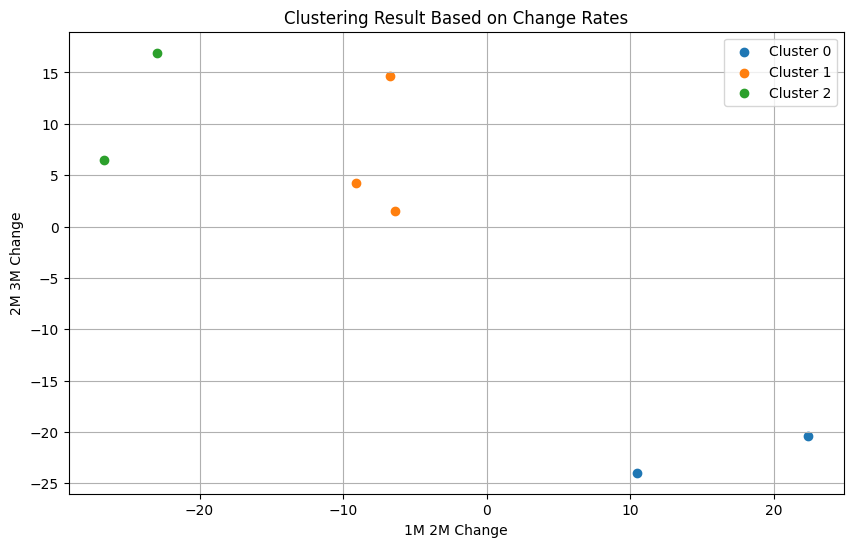

In [ ]:

# 군집 결과 산점도 시각화
plt.figure(figsize=(10, 6))

# 각 군집에 대해 산점도 그리기
for cluster in sorted(New_DF_no_outliers['Cluster'].dropna().unique()):
    cluster_data = New_DF_no_outliers[New_DF_no_outliers['Cluster'] == cluster]
    plt.scatter(cluster_data['1_2'], cluster_data['2_3'], label=f'Cluster {int(cluster)}')

# 그래프 설정
plt.xlabel('1M 2M Change')
plt.ylabel('2M 3M Change')
plt.title('Clustering Result Based on Change Rates')
plt.legend()
plt.grid(True)
plt.show()


In [247]:
# 클러스터 정렬
print(New_DF_no_outliers.sort_values(by='Cluster').reset_index(drop=True))



                 DIV        1_2        2_3        변화율  Cluster  \
0        Youth Pants  22.399803 -20.431457   0.984173        0   
1         Wet Tissue  10.474232 -23.973586  -6.749677        0   
2  Baby & Child Care  -6.719319  14.693040   3.986860        1   
3        Family Care  -6.368800   1.476738  -2.446031        1   
4      Feminine Care  -9.125756   4.198600  -2.463578        1   
5        Health Care -26.675148   6.468941 -10.103104        2   
6          Skin Care -22.971924  16.925665  -3.023130        2   

   Silhouette Score  
0          0.702150  
1          0.668453  
2          0.326265  
3          0.589879  
4          0.581369  
5          0.413029  
6          0.401655  


클러스터 0: 1월에서 2월 사이 증가 후 2월에서 3월 사이 많이 감소. 
(Youth Pants, Wet Tissue)

클러스터 1: 1월에서 2월 사이 약간의 감소 후 2월에서 3월 사이 증가.
(Baby & Child Care, Family Care, Feminine Care)

클러스터 2: 1월에서 2월 사이 큰 감소 후 2월에서 3월 사이 증가.
(Health Care, Skin Care)